<a href="https://colab.research.google.com/github/PeterG2001/Portfolio/blob/main/Deep_Learning_Semantic_Segmentation_with_the_Cambridge_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
from IPython.display import clear_output as cls
!pip install tf_explain
cls()

In [ ]:
# Common
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf

# Data 
import tensorflow.data as tfd
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array

# Data Visualization
import matplotlib.pyplot as plt

# Model
from keras.layers import ReLU
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Concatenate
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from tensorflow.keras.applications import ResNet50

# Callbacks 
from keras.callbacks import Callback, ModelCheckpoint

# Model Visualization
from tensorflow.keras.utils import plot_model

#Data Loading and Augmentation


In [ ]:

train_path = '/content/drive/MyDrive/Colab Notebooks/Assignment 3/Cam101/Cam101/'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Assignment 3/Cam101/Cam101/'
test_path = '/content/drive/MyDrive/Colab Notebooks/Assignment 3/Cam101/Cam101/'

In [ ]:
import random
import albumentations as A

def augment_data(image, mask):
    # Convert image and mask to uint8 format
    image = (image * 255).astype(np.uint8)
    mask = (mask * 255).astype(np.uint8)

    # Define augmentation transformations
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ])

    # Apply the same augmentation to image and mask
    augmented = transform(image=image, mask=mask)

    # Retrieve augmented image and mask
    augmented_image = augmented['image']
    augmented_mask = augmented['mask']

    # Convert augmented image and mask back to float32 format
    augmented_image = augmented_image.astype(np.float32) / 255.0
    augmented_mask = augmented_mask.astype(np.float32) / 255.0

    return augmented_image, augmented_mask

def load_image(path, image_size=256):
    image = Image.open(path)
    image = image.resize((image_size, image_size))
    image = img_to_array(image)
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image

def load_data(root_path, data, trim=None, augment=False):
    images = []
    label_maps = []

    # Get the image paths and sort them
    image_paths = sorted(glob(os.path.join(root_path, data, '*.png')))

    for image_path in tqdm(image_paths, desc="Loading"):
        # Extract the filename and extension
        filename = os.path.basename(image_path)

        # Check if it is an image or mask based on the filename
        if filename.endswith('_L.png'):
            # Corresponds to a mask file
            mask = load_image(image_path)
            label_maps.append(mask)
        else:
            # Corresponds to an image file
            image = load_image(image_path)
            images.append(image)

    if trim is not None:
        images = images[:trim]
        label_maps = label_maps[:trim]

    # Convert the lists to NumPy arrays
    images = np.array(images)
    label_maps = np.array(label_maps)
    if isinstance(images, np.ndarray):
      print("train_images is a NumPy array")
    else:
      print("train_images is not a NumPy array")
    print("train_images shape:", images.shape)
    print("train_label_maps shape:", label_maps.shape)
    print("train_images dtype:", images.dtype)
    print("train_label_maps dtype:", label_maps.dtype)
    if augment and data == 'train':
        augmented_images = []
        augmented_label_maps = []
        for image, mask in zip(images, label_maps):
            augmented_image, augmented_mask = augment_data(image, mask)
            augmented_images.append(augmented_image)
            augmented_label_maps.append(augmented_mask)

        images = np.array(augmented_images)
        label_maps = np.array(augmented_label_maps)
        if isinstance(images, np.ndarray):
          print("train_images is a NumPy array")
        else:
          print("train_images is not a NumPy array")
        print("train_images shape:", images.shape)
        print("train_label_maps shape:", label_maps.shape)

    return images, label_maps

In [ ]:
# Params
AUTO = tfd.AUTOTUNE
BATCH_SIZE = 5

#Print out the number of training and testing samples in the dataset.

In [ ]:
# Load Training Data with Augmentation
train_images, train_label_maps = load_data(train_path, data='train', augment=True)

# Converting to TF Data
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_label_maps))
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(AUTO)


Loading: 100%|██████████| 162/162 [00:04<00:00, 39.39it/s]


train_images is a NumPy array
train_images shape: (81, 256, 256, 3)
train_label_maps shape: (81, 256, 256, 3)
train_images dtype: float32
train_label_maps dtype: float32
train_images is a NumPy array
train_images shape: (81, 256, 256, 3)
train_label_maps shape: (81, 256, 256, 3)


In [ ]:
# Load Data
valid_images, valid_label_maps = load_data(valid_path, data='val')

# Converting to TF Data
valid_ds = tfd.Dataset.from_tensor_slices((valid_images, valid_label_maps))
valid_ds = valid_ds.batch(BATCH_SIZE, drop_remainder=True)
valid_ds = valid_ds.prefetch(AUTO)

Loading: 100%|██████████| 18/18 [00:00<00:00, 38.02it/s]

train_images is a NumPy array
train_images shape: (9, 256, 256, 3)
train_label_maps shape: (9, 256, 256, 3)
train_images dtype: float32
train_label_maps dtype: float32


In [ ]:
# Load Data
test_images, test_label_maps = load_data(test_path, data='test', trim=50)

# Converting to TF Data
test_ds = tfd.Dataset.from_tensor_slices((test_images, test_label_maps))
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.prefetch(AUTO)

Loading: 100%|██████████| 22/22 [00:00<00:00, 37.65it/s]

train_images is a NumPy array
train_images shape: (11, 256, 256, 3)
train_label_maps shape: (11, 256, 256, 3)
train_images dtype: float32
train_label_maps dtype: float32


#Plot some figures to visualize some samples.

In [ ]:
def show_maps(data, n_images=2, model=None, SIZE=(10,13.3), ALPHA=0.5, explain=False):
    # plot Configurations
    if model is not None:
        n_cols = 4
    else:
        n_cols = 3
    
    # Select the Data
    images, label_maps = next(iter(data))
    
    # Create N plots where N = Number of Images
    for image_no in range(n_images):
        # Figure Size
        plt.figure(figsize=SIZE)
        
        # Select Image and Label Map
        id = np.random.randint(len(images))
        image, label_map = images[id], label_maps[id]
        
        # Plot Image 
        plt.subplot(1, n_cols, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')

        # Plot Original Label Map
        plt.subplot(1, n_cols, 2)
        plt.imshow(label_map)
        plt.title('Original Label Map')
        plt.axis('off')
        
        # Plot Mixed Overlap
        plt.subplot(1, n_cols, 3)
        plt.imshow(image)
        plt.imshow(label_map, alpha=ALPHA)
        plt.title("Overlap")
        plt.axis('off')

        if model is not None:
            # Plot Predicted Label Map
            plt.subplot(1, n_cols, 4)
            pred_map = model.predict(image[np.newaxis, ...])[0]
            plt.imshow(pred_map)
            plt.title('Predicted Label Map')
            plt.axis('off')

        # Final Show
        plt.show()

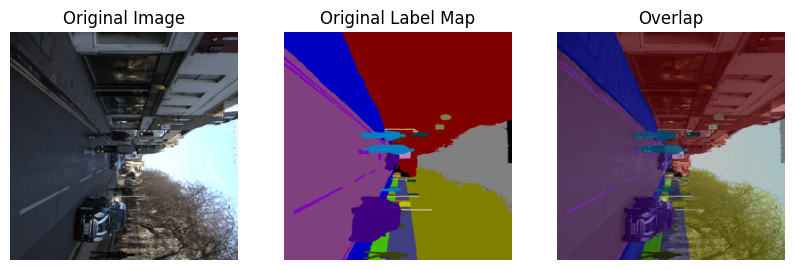

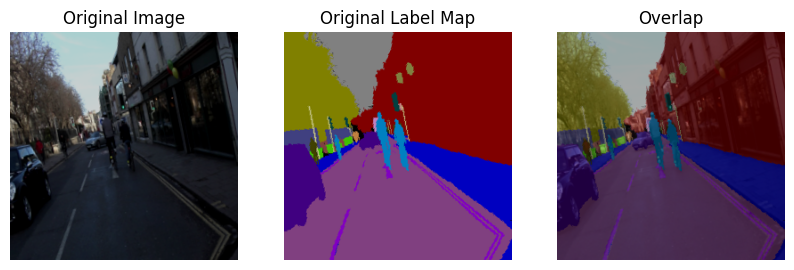

In [ ]:
show_maps(data=train_ds)

#DeepLabv3+

DeepLabv3+ is an extension of the DeepLabv3 architecture that incorporates an encoder-decoder structure. This architecture aims to improve semantic segmentation by effectively capturing both local and global contextual information.

The encoder module in DeepLabv3+ utilizes dilated convolutions at multiple scales. Dilated convolutions have a larger receptive field compared to regular convolutions, allowing them to capture information from a wider context without sacrificing spatial resolution. By applying dilated convolutions at different dilation rates, the encoder module can capture multiscale contextual information. This helps the model understand objects of various sizes and effectively capture their semantic context.

The decoder module in DeepLabv3+ focuses on refining the segmentation results along object boundaries. It takes the high-level features extracted by the encoder module and employs a decoder network to refine the segmentation masks. The decoder network combines the high-level features with low-level features from earlier layers to enhance the spatial resolution and capture more fine-grained details. This refinement along object boundaries improves the accuracy and precision of the segmentation results, especially in regions with intricate object boundaries.

Overall, DeepLabv3+ combines the benefits of dilated convolutions for capturing multiscale contextual information with the refinement capabilities of the decoder module to achieve accurate and detailed semantic segmentation. This architecture has been widely used in various computer vision tasks such as image segmentation, object detection, and scene understanding.

In [ ]:

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Concatenate, GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, UpSampling2D

def ConvBlock(inputs, filters, kernel_size, dilation_rate):
    x = Conv2D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def AtrousSpatialPyramidPooling(inputs):
    pool_size = inputs.shape[1:3]
    
    # Image Pooling Branch
    image_pool = GlobalAveragePooling2D()(inputs)
    image_pool = Reshape((1, 1, -1))(image_pool)
    image_pool = ConvBlock(image_pool, filters=256, kernel_size=1, dilation_rate=1)
    image_pool = UpSampling2D(size=pool_size, interpolation='bilinear')(image_pool)
    
    # Atrous Convolution Branches
    conv_1 = ConvBlock(inputs, filters=256, kernel_size=1, dilation_rate=1)
    conv_6 = ConvBlock(inputs, filters=256, kernel_size=3, dilation_rate=6)
    conv_12 = ConvBlock(inputs, filters=256, kernel_size=3, dilation_rate=12)
    conv_18 = ConvBlock(inputs, filters=256, kernel_size=3, dilation_rate=18)
    
    # Concatenate and Output
    concatenated = Concatenate()([image_pool, conv_1, conv_6, conv_12, conv_18])
    output = ConvBlock(concatenated, filters=256, kernel_size=1, dilation_rate=1)
    
    return output

def build_model(hp):
    # Input Layer
    IMAGE_SIZE = 256
    input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="Input-Layer")

    # Base Model
    base_model = ResNet50(include_top=False, input_tensor=input_layer, weights='imagenet')

    # DeepLab Output
    dcnn_output = base_model.get_layer('conv4_block6_2_relu').output
    aspp_output = AtrousSpatialPyramidPooling(dcnn_output)
    aspp_output = UpSampling2D(size=(IMAGE_SIZE//4//aspp_output.shape[1], IMAGE_SIZE//4//aspp_output.shape[2]), interpolation='bilinear', name="Atrous-Upscale")(aspp_output)

    # Low-Level Features
    llf_output = base_model.get_layer('conv2_block3_2_relu').output
    llf_output = ConvBlock(llf_output, filters=48, kernel_size=1, dilation_rate=1)

    # Combine Features
    combined_features = Concatenate(axis=-1, name="Combine-Features")([aspp_output, llf_output])
    top_cb_1_output = ConvBlock(combined_features, filters=256, kernel_size=3, dilation_rate=1)
    top_cb_2_output = ConvBlock(top_cb_1_output, filters=256, kernel_size=3, dilation_rate=1)
    upsampled_output = UpSampling2D(size=(IMAGE_SIZE//top_cb_2_output.shape[1], IMAGE_SIZE//top_cb_2_output.shape[1]), interpolation='bilinear', name="Top-UpSample")(top_cb_2_output)
    label_map = Conv2D(filters=3, kernel_size=1, strides=1, activation='sigmoid', padding='same', name="OutputLayer")(upsampled_output)

    # Create Model
    model = Model(input_layer, label_map, name="DeepLabV3-Plus")

    # Compile Model
    loss = hp.Choice('loss', ['binary_crossentropy', 'categorical_crossentropy'])
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log')

    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), tf.keras.metrics.BinaryAccuracy()])

    return model


In [ ]:
!pip install keras-tuner

import kerastuner as kt
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='deeplabresult'
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tuner.search(train_ds, validation_data=valid_ds, epochs=50)


Trial 30 Complete [00h 01m 20s]
val_accuracy: 0.7957794070243835

Best val_accuracy So Far: 0.7957794070243835
Total elapsed time: 00h 23m 42s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

In [ ]:
print("Best Hyperparameters:")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")
print(f"- Optimizer: {best_hps.get('optimizer')}")
print(f"- Loss: {best_hps.get('loss')}")

Best Hyperparameters:
- Learning Rate: 0.005203649484378387
- Optimizer: adam
- Loss: categorical_crossentropy


In [ ]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        show_maps(data=valid_ds, model=self.model, n_images=1)

In [ ]:
strategy = tf.distribute.OneDeviceStrategy("GPU:0")

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate'))
model.compile(optimizer=optimizer,
              loss=best_hps.get('loss'),
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), tf.keras.metrics.BinaryAccuracy()])

history=model.fit(train_ds, validation_data=valid_ds, epochs=50)


Epoch 1/50
16/16 [==============================] - 38s 202ms/step - loss: 3.4097 - accuracy: 0.7816 - mean_io_u_4: 0.2489 - binary_accuracy: 0.2586 - val_loss: 1.2988 - val_accuracy: 0.7915 - val_mean_io_u_4: 0.3398 - val_binary_accuracy: 0.1792
Epoch 2/50
16/16 [==============================] - 2s 118ms/step - loss: 1.4404 - accuracy: 0.7811 - mean_io_u_4: 0.2400 - binary_accuracy: 0.2533 - val_loss: 1.4662 - val_accuracy: 0.7953 - val_mean_io_u_4: 0.2914 - val_binary_accuracy: 0.2313
Epoch 3/50
16/16 [==============================] - 2s 118ms/step - loss: 1.0652 - accuracy: 0.7813 - mean_io_u_4: 0.2449 - binary_accuracy: 0.2570 - val_loss: 1.1429 - val_accuracy: 0.7900 - val_mean_io_u_4: 0.3276 - val_binary_accuracy: 0.2002
Epoch 4/50
16/16 [==============================] - 2s 119ms/step - loss: 0.9399 - accuracy: 0.7814 - mean_io_u_4: 0.2525 - binary_accuracy: 0.2603 - val_loss: 1.0496 - val_accuracy: 0.7907 - val_mean_io_u_4: 0.2994 - val_binary_accuracy: 0.1840
Epoch 5/50
16/1

In [ ]:
# Callbacks 
cbs = [ModelCheckpoint("DeepLabV3+.h5",save_best_only=False),ShowProgress()]

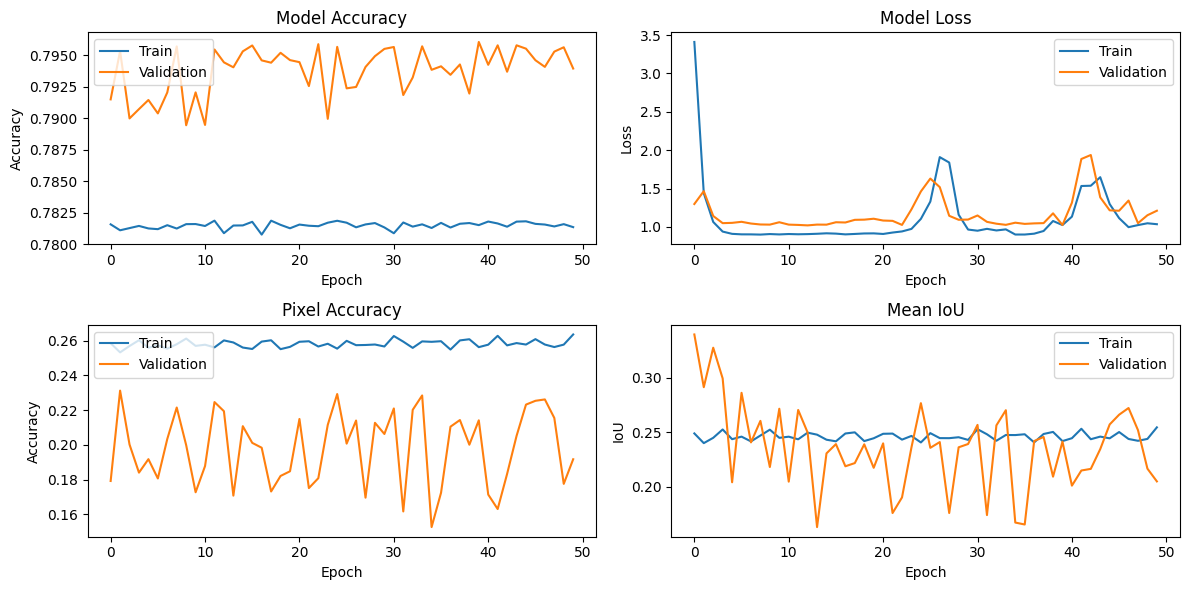

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot pixel accuracy
plt.subplot(2, 2, 3)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Pixel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot mean IoU
plt.subplot(2, 2, 4)
plt.plot(history.history['mean_io_u_4'])
plt.plot(history.history['val_mean_io_u_4'])
plt.title('Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy, test_mean_io_u, test_binary_accuracy = model.evaluate(test_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test MeanIoU:", test_mean_io_u)
print("Test Binary Accuracy:", test_binary_accuracy)

2/2 [==============================] - 0s 70ms/step - loss: 1.0872 - accuracy: 0.7805 - mean_io_u_4: 0.2169 - binary_accuracy: 0.2443
Test Loss: 1.0872451066970825
Test Accuracy: 0.7804504632949829
Test MeanIoU: 0.21685689687728882
Test Binary Accuracy: 0.24431203305721283


In [ ]:
def Conv2dBlock(inputTensor, numFilters, kernelSize=3, doBatchNorm=True):
    # First Convolution
    x = tf.keras.layers.Conv2D(filters=numFilters, kernel_size=(kernelSize, kernelSize),
                               kernel_initializer='he_normal', padding='same')(inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.LeakyReLU()(x)  # Using LeakyReLU activation instead of ReLU

    # Second Convolution
    x = tf.keras.layers.Conv2D(filters=numFilters, kernel_size=(kernelSize, kernelSize),
                               kernel_initializer='he_normal', padding='same')(x)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.LeakyReLU()(x)  # Using LeakyReLU activation instead of ReLU

    return x

def Unet(hp):
    numFilters = hp.Choice('numFilters', values=[16, 32, 64])
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    doBatchNorm = hp.Boolean('doBatchNorm')
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    learningRate = hp.Choice('learningRate', values=[0.001, 0.01, 0.1])
    loss = hp.Choice('loss', values=['binary_crossentropy', 'mean_squared_error'])
    
    inputImage = tf.keras.Input(shape=(256, 256, 3))
    
    # Encoder
    c1 = Conv2dBlock(inputImage, numFilters, kernelSize=3, doBatchNorm=doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(dropout)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize=3, doBatchNorm=doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(dropout)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize=3, doBatchNorm=doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(dropout)(p3)

    # Bridge
    b1 = Conv2dBlock(p3, numFilters * 8, kernelSize=3, doBatchNorm=doBatchNorm)

    # Decoder
    u1 = tf.keras.layers.Conv2DTranspose(numFilters * 4, (3, 3), strides=(2, 2), padding='same')(b1)
    u1 = tf.keras.layers.concatenate([u1, c3])
    u1 = tf.keras.layers.Dropout(dropout)(u1)
    c4 = Conv2dBlock(u1, numFilters * 4, kernelSize=3, doBatchNorm=doBatchNorm)

    u2 = tf.keras.layers.Conv2DTranspose(numFilters * 2, (3, 3), strides=(2, 2), padding='same')(c4)
    u2 = tf.keras.layers.concatenate([u2, c2])
    u2 = tf.keras.layers.Dropout(dropout)(u2)
    c5 = Conv2dBlock(u2, numFilters * 2, kernelSize=3, doBatchNorm=doBatchNorm)

    u3 = tf.keras.layers.Conv2DTranspose(numFilters, (3, 3), strides=(2, 2), padding='same')(c5)
    u3 = tf.keras.layers.concatenate([u3, c1])
    u3 = tf.keras.layers.Dropout(dropout)(u3)
    c6 = Conv2dBlock(u3, numFilters, kernelSize=3, doBatchNorm=doBatchNorm)

    # Output
    output = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(c6)

    model = tf.keras.Model(inputs=[inputImage], outputs=[output])

    # Set optimizer, learning rate, and loss function
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learningRate)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=optimizer, loss=loss)

    return model



In [ ]:
tuner = kt.Hyperband(Unet,
                     objective='val_loss',
                     max_epochs=20,
                     factor=3,
                     directory='Unet')

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Perform the hyperparameter search
tuner.search(train_ds,
             validation_data=valid_ds,
             callbacks=[early_stopping])

# Get the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the final model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
model.fit(train_ds,
          validation_data=valid_ds,
          epochs=10,
          callbacks=[early_stopping])

Trial 24 Complete [00h 00m 35s]
val_loss: 0.6574296951293945

Best val_loss So Far: 0.044445306062698364
Total elapsed time: 00h 05m 12s
Epoch 1/10
16/16 [==============================] - 5s 146ms/step - loss: 0.0802 - val_loss: 0.0535
Epoch 2/10
16/16 [==============================] - 2s 130ms/step - loss: 0.0691 - val_loss: 0.0517
Epoch 3/10
16/16 [==============================] - 2s 129ms/step - loss: 0.0652 - val_loss: 0.0501
Epoch 4/10
16/16 [==============================] - 2s 129ms/step - loss: 0.0619 - val_loss: 0.0486
Epoch 5/10
16/16 [==============================] - 2s 129ms/step - loss: 0.0588 - val_loss: 0.0472
Epoch 6/10
16/16 [==============================] - 2s 129ms/step - loss: 0.0561 - val_loss: 0.0460
Epoch 7/10
16/16 [==============================] - 2s 130ms/step - loss: 0.0538 - val_loss: 0.0451
Epoch 8/10
16/16 [==============================] - 2s 129ms/step - loss: 0.0520 - val_loss: 0.0446
Epoch 9/10
16/16 [==============================] - 2s 129ms/st

In [ ]:
print("Best Hyperparameters:")
print("numFilters:", best_hps.get('numFilters'))
print("dropout:", best_hps.get('dropout'))
print("doBatchNorm:", best_hps.get('doBatchNorm'))
print("optimizer:", best_hps.get('optimizer'))
print("learningRate:", best_hps.get('learningRate'))
print("loss:", best_hps.get('loss'))

Best Hyperparameters:
numFilters: 32
dropout: 0.4
doBatchNorm: False
optimizer: sgd
learningRate: 0.1
loss: mean_squared_error


In [ ]:
num_filters = best_hps.get('numFilters')
dropout_rate = best_hps.get('dropout')
do_batch_norm = best_hps.get('doBatchNorm')

optimizer = tf.keras.optimizers.Adam(learning_rate=best_hps.get('learningRate'))
model.compile(optimizer=optimizer,
              loss=best_hps.get('loss'),
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_ds, validation_data=valid_ds, epochs=50)

Epoch 1/50
16/16 [==============================] - 9s 161ms/step - loss: 0.1568 - accuracy: 0.7779 - mean_io_u: 1.0000 - binary_accuracy: 0.2935 - val_loss: 0.1687 - val_accuracy: 0.7958 - val_mean_io_u: 1.0000 - val_binary_accuracy: 0.2415
Epoch 2/50
16/16 [==============================] - 2s 129ms/step - loss: 0.1635 - accuracy: 0.7795 - mean_io_u: 1.0000 - binary_accuracy: 0.2936 - val_loss: 0.1687 - val_accuracy: 0.7958 - val_mean_io_u: 1.0000 - val_binary_accuracy: 0.2415
Epoch 3/50
16/16 [==============================] - 2s 129ms/step - loss: 0.1635 - accuracy: 0.7795 - mean_io_u: 1.0000 - binary_accuracy: 0.2936 - val_loss: 0.1687 - val_accuracy: 0.7958 - val_mean_io_u: 1.0000 - val_binary_accuracy: 0.2415
Epoch 4/50
16/16 [==============================] - 2s 129ms/step - loss: 0.1635 - accuracy: 0.7795 - mean_io_u: 1.0000 - binary_accuracy: 0.2936 - val_loss: 0.1687 - val_accuracy: 0.7958 - val_mean_io_u: 1.0000 - val_binary_accuracy: 0.2415
Epoch 5/50
16/16 [==============

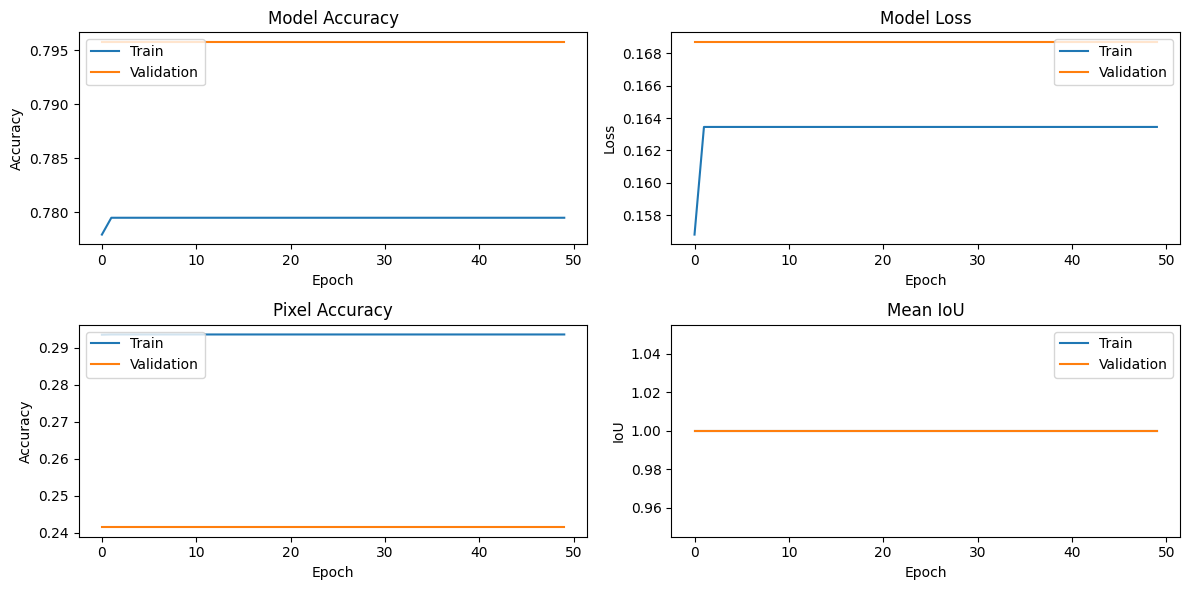

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot pixel accuracy
plt.subplot(2, 2, 3)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Pixel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot mean IoU
plt.subplot(2, 2, 4)
plt.plot(history.history['mean_io_u'])
plt.plot(history.history['val_mean_io_u'])
plt.title('Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy, test_mean_io_u, test_binary_accuracy = model.evaluate(test_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test MeanIoU:", test_mean_io_u)
print("Test Binary Accuracy:", test_binary_accuracy)

2/2 [==============================] - 0s 63ms/step - loss: 0.1619 - accuracy: 0.7809 - mean_io_u: 1.0000 - binary_accuracy: 0.3040
Test Loss: 0.16186125576496124
Test Accuracy: 0.7809478640556335
Test MeanIoU: 1.0
Test Binary Accuracy: 0.3040471374988556


The code you provided defines a SegNet model using the Keras API. The model follows the SegNet architecture, which consists of an encoder and a decoder.

The encoder part of the SegNet model is responsible for downsampling the input image and extracting features. It consists of several convolutional layers, batch normalization layers, and ReLU activation functions. The encoder progressively reduces the spatial dimensions of the feature maps while increasing the number of channels.

The decoder part of the SegNet model is responsible for upsampling the low-resolution feature maps from the encoder and generating the segmentation output. It mirrors the structure of the encoder but uses upsampling layers (such as UpSampling2D) instead of pooling layers to increase the spatial dimensions. The decoder also includes skip connections that concatenate the feature maps from the corresponding encoder layers to preserve spatial information.

The model is compiled with the specified loss function and metrics. The Conv2D layers use the He normal initialization (KERNEL) for the kernel weights, and the BatchNormalization layers help stabilize and accelerate the training process.

To use this model, you can call the segnet(input_shape, n_classes) function, passing the desired input shape and the number of classes as arguments. The function will return an instance of the SegNet model.

In [ ]:
import kerastuner as kt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def Segnet(hp):
    input_shape = (256, 256, 3)
    n_classes = 10
    # Encoder
    num_filters = hp.Choice('num_filters', values=[32, 64, 128, 256])
    kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
    x = Conv2D(num_filters, kernel_size, padding='same')(input_shape)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    p_1 = MaxPooling2D(pool_size=2)(x)

    num_filters *= 2
    x = Conv2D(num_filters, kernel_size, padding='same')(p_1)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    p_2 = MaxPooling2D(pool_size=2)(x)

    num_filters *= 2
    x = Conv2D(num_filters, kernel_size, padding='same')(p_2)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    p_3 = MaxPooling2D(pool_size=2)(x)

    num_filters *= 2
    x = Conv2D(num_filters, kernel_size, padding='same')(p_3)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    p_4 = MaxPooling2D(pool_size=2)(x)

    num_filters *= 2
    x = Conv2D(num_filters, kernel_size, padding='same')(p_4)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Decoder
    num_filters //= 2
    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Concatenate()([x, p_4])
    num_filters //= 2
    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Concatenate()([x, p_3])
    num_filters //= 2
    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Concatenate()([x, p_2])
    num_filters //= 2
    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Concatenate()([x, p_1])
    num_filters //= 2
    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    outputs = Conv2D(n_classes, 1, activation='softmax')(x)

    model = Model(inputs=input_shape, outputs=outputs)

    return model

In [ ]:
# Define the Keras Tuner search space
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=20, factor=3, directory='segnet')

# Perform the hyperparameter search
tuner.search(train_ds, epochs=10, validation_data= valid_ds)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and compile the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)
model.fit(train_ds,
          validation_data=valid_ds,
          epochs=10,
          callbacks=[early_stopping])

print("Best Hyperparameters:")
print("numFilters:", best_hps.get('numFilters'))
print("dropout:", best_hps.get('dropout'))
print("doBatchNorm:", best_hps.get('doBatchNorm'))
print("optimizer:", best_hps.get('optimizer'))
print("learningRate:", best_hps.get('learningRate'))
print("loss:", best_hps.get('loss'))

num_filters = best_hps.get('numFilters')
dropout_rate = best_hps.get('dropout')
do_batch_norm = best_hps.get('doBatchNorm')



TypeError: ignored

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=best_hps.get('learningRate'))
model.compile(optimizer=optimizer,
              loss=best_hps.get('loss'),
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_ds, validation_data=valid_ds, epochs=50)

Epoch 1/50
16/16 [==============================] - 9s 161ms/step - loss: 0.1635 - accuracy: 0.7795 - mean_io_u_1: 1.0000 - binary_accuracy: 0.2936 - val_loss: 0.1687 - val_accuracy: 0.7958 - val_mean_io_u_1: 1.0000 - val_binary_accuracy: 0.2415
Epoch 2/50
16/16 [==============================] - 2s 130ms/step - loss: 0.1635 - accuracy: 0.7795 - mean_io_u_1: 1.0000 - binary_accuracy: 0.2936 - val_loss: 0.1687 - val_accuracy: 0.7958 - val_mean_io_u_1: 1.0000 - val_binary_accuracy: 0.2415
Epoch 3/50
16/16 [==============================] - 2s 129ms/step - loss: 0.1635 - accuracy: 0.7795 - mean_io_u_1: 1.0000 - binary_accuracy: 0.2936 - val_loss: 0.1687 - val_accuracy: 0.7958 - val_mean_io_u_1: 1.0000 - val_binary_accuracy: 0.2415
Epoch 4/50
16/16 [==============================] - 2s 129ms/step - loss: 0.1635 - accuracy: 0.7795 - mean_io_u_1: 1.0000 - binary_accuracy: 0.2936 - val_loss: 0.1687 - val_accuracy: 0.7958 - val_mean_io_u_1: 1.0000 - val_binary_accuracy: 0.2415
Epoch 5/50
16/16

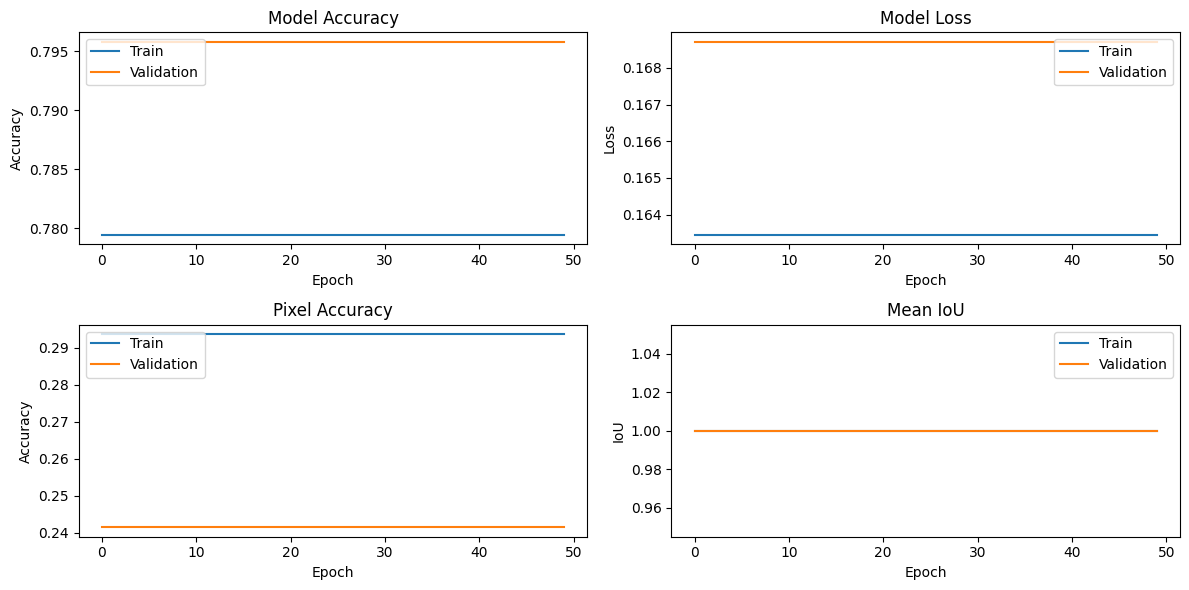

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot pixel accuracy
plt.subplot(2, 2, 3)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Pixel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot mean IoU
plt.subplot(2, 2, 4)
plt.plot(history.history['mean_io_u_1'])
plt.plot(history.history['val_mean_io_u_1'])
plt.title('Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy, test_mean_io_u, test_binary_accuracy = model.evaluate(test_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test MeanIoU:", test_mean_io_u)
print("Test Binary Accuracy:", test_binary_accuracy)

2/2 [==============================] - 0s 64ms/step - loss: 0.1619 - accuracy: 0.7809 - mean_io_u_1: 1.0000 - binary_accuracy: 0.3040
Test Loss: 0.16186125576496124
Test Accuracy: 0.7809478640556335
Test MeanIoU: 1.0
Test Binary Accuracy: 0.3040471374988556
